#**Install and Import Required Libraries**

In [1]:
!pip install kaggle pillow matplotlib seaborn opencv-python scikit-learn tensorflow

import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter
import random


#**Setup Kaggle API and Download Dataset**

In [2]:
from google.colab import files
print("Upload your kaggle.json file:")
uploaded = files.upload()

os.makedirs('/root/.kaggle', exist_ok=True)
os.rename('kaggle.json', '/root/.kaggle/kaggle.json')
os.chmod('/root/.kaggle/kaggle.json', 600)

!kaggle datasets download -d mahmoudima/mma-facial-expression


Upload your kaggle.json file:


Saving kaggle.json to kaggle (1).json
Dataset URL: https://www.kaggle.com/datasets/mahmoudima/mma-facial-expression
License(s): unknown
 58% 96.0M/166M [00:00<00:00, 1.01GB/s]
100% 166M/166M [00:00<00:00, 814MB/s]  


#**Extract and Explore Dataset Structure**

In [3]:
with zipfile.ZipFile('mma-facial-expression.zip', 'r') as zip_ref:
    zip_ref.extractall('mma_dataset')

os.listdir('mma_dataset')


['MMAFEDB']

In [4]:
with zipfile.ZipFile('mma-facial-expression.zip', 'r') as zip_ref:
    zip_ref.extractall('mma_dataset')

os.listdir('mma_dataset')


['MMAFEDB']

In [8]:
dataset_path = 'mma_dataset/MMAFEDB'
subdirs = os.listdir(dataset_path)
print("Main directories:", subdirs)

for subdir in subdirs:
    full_path = os.path.join(dataset_path, subdir)
    if os.path.isdir(full_path):
        print(f"\n{subdir} contains:")
        emotion_classes = os.listdir(full_path)
        print(emotion_classes)

Main directories: ['valid', 'train', 'test']

valid contains:
['angry', 'sad', 'surprise', 'fear', 'neutral', 'happy', 'disgust']

train contains:
['angry', 'sad', 'surprise', 'fear', 'neutral', 'happy', 'disgust']

test contains:
['angry', 'sad', 'surprise', 'fear', 'neutral', 'happy', 'disgust']


In [20]:
train_dir = os.path.join(dataset_path, 'train')
val_dir = os.path.join(dataset_path, 'valid')
test_dir = os.path.join(dataset_path, 'test')

emotion_classes = os.listdir(train_dir)
emotion_classes.sort()
print("Emotion classes:", emotion_classes)
print("Number of classes:", len(emotion_classes))

Emotion classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Number of classes: 7


#**Count Images Per Class in Each Split**

In [10]:
def count_images_per_class(directory):
    counts = {}
    for emotion in emotion_classes:
        emotion_path = os.path.join(directory, emotion)
        if os.path.exists(emotion_path):
            counts[emotion] = len(os.listdir(emotion_path))
        else:
            counts[emotion] = 0
    return counts

train_counts = count_images_per_class(train_dir)
val_counts = count_images_per_class(val_dir)
test_counts = count_images_per_class(test_dir)

print("Training set counts:")
for emotion, count in train_counts.items():
    print(f"{emotion}: {count}")

print("\nTotal training images:", sum(train_counts.values()))


Training set counts:
angry: 6566
disgust: 3231
fear: 4859
happy: 28592
neutral: 29384
sad: 12223
surprise: 8113

Total training images: 92968


# **Display Sample Images from Each Class**

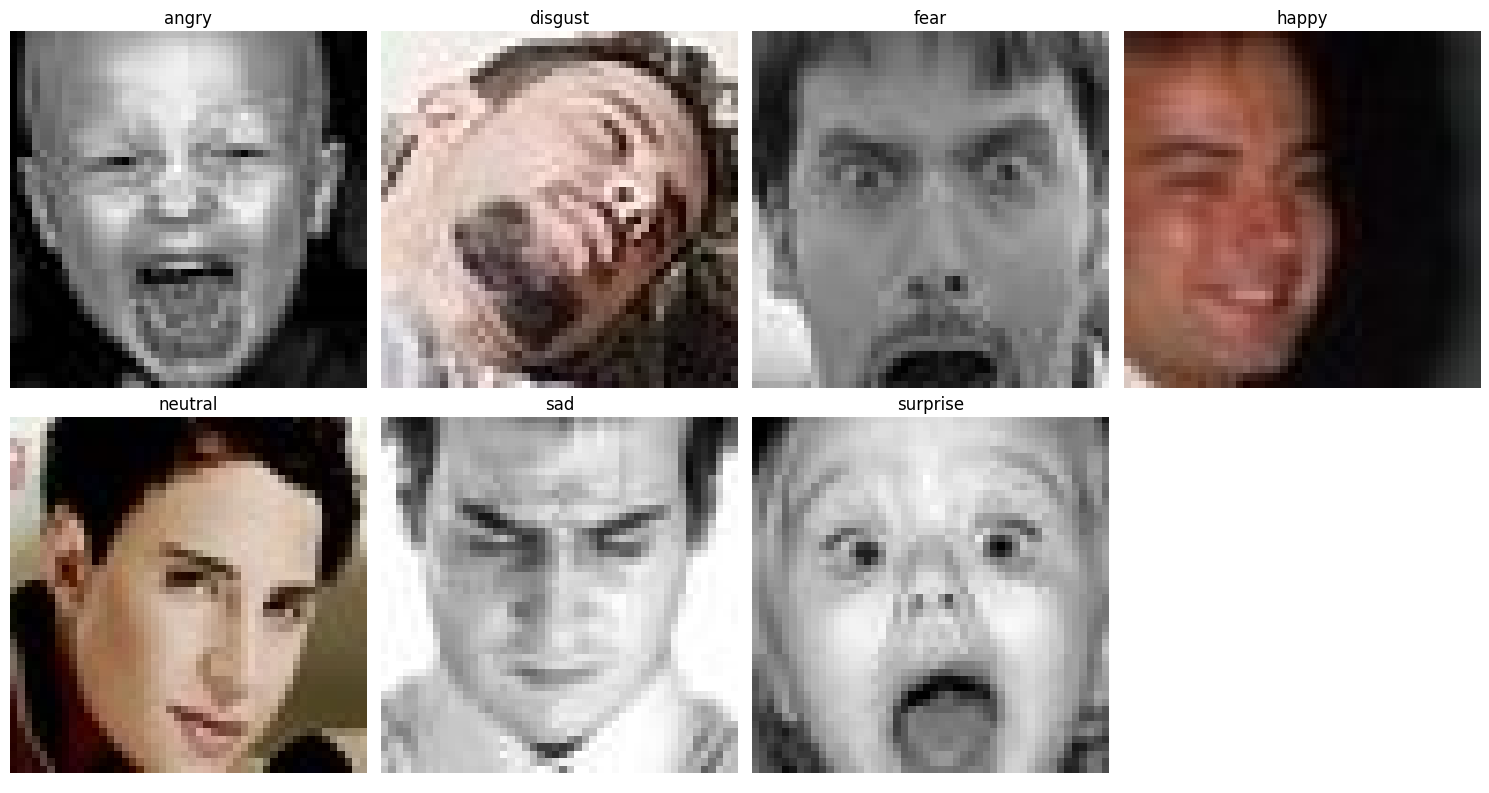

In [11]:
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
axes = axes.flatten()

for i, emotion in enumerate(emotion_classes[:7]):
    emotion_path = os.path.join(train_dir, emotion)
    image_files = os.listdir(emotion_path)
    sample_image = random.choice(image_files)
    img_path = os.path.join(emotion_path, sample_image)

    img = Image.open(img_path)
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(emotion)
    axes[i].axis('off')

axes[7].axis('off')
plt.tight_layout()
plt.show()


#  Histogram Equalization for Contrast Enhancement

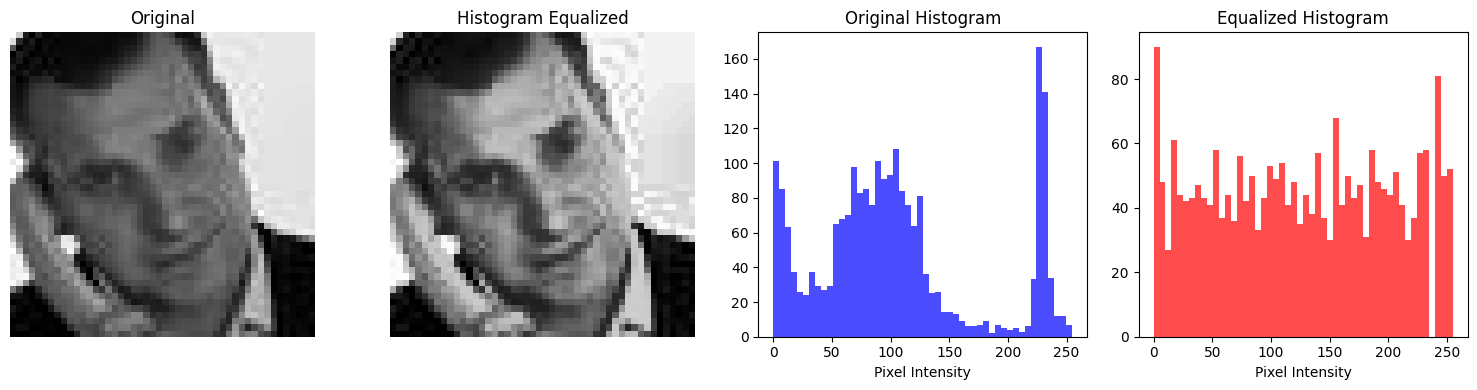

In [23]:
def apply_histogram_equalization(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    equalized = cv2.equalizeHist(img)
    return img, equalized

sample_emotion = emotion_classes[0]
sample_path = os.path.join(train_dir, sample_emotion)
sample_file = os.listdir(sample_path)[0]
img_path = os.path.join(sample_path, sample_file)

original, equalized = apply_histogram_equalization(img_path)

fig, axes = plt.subplots(1, 4, figsize=(15, 4))
axes[0].imshow(original, cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')

axes[1].imshow(equalized, cmap='gray')
axes[1].set_title('Histogram Equalized')
axes[1].axis('off')

axes[2].hist(original.flatten(), bins=50, alpha=0.7, color='blue')
axes[2].set_title('Original Histogram')
axes[2].set_xlabel('Pixel Intensity')

axes[3].hist(equalized.flatten(), bins=50, alpha=0.7, color='red')
axes[3].set_title('Equalized Histogram')
axes[3].set_xlabel('Pixel Intensity')

plt.tight_layout()
plt.show()


 # **Gaussian Blur for Noise Reduction**

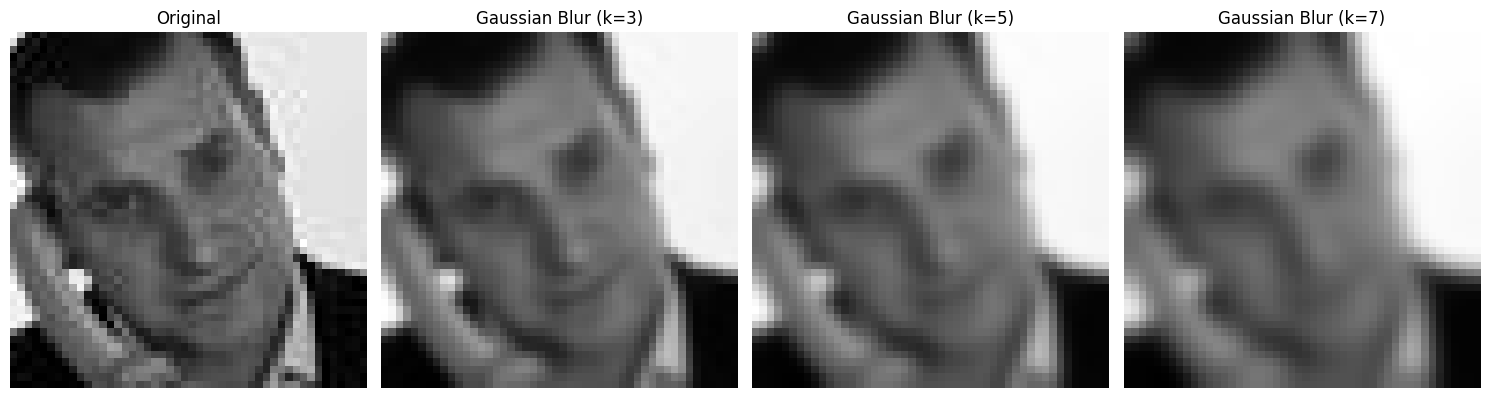

In [24]:
def apply_gaussian_blur(image_path, kernel_sizes=[3, 5, 7]):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    blurred_images = []

    for kernel_size in kernel_sizes:
        blurred = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
        blurred_images.append(blurred)

    return img, blurred_images

original, blurred_list = apply_gaussian_blur(img_path)

fig, axes = plt.subplots(1, 4, figsize=(15, 4))
axes[0].imshow(original, cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')

for i, (blurred, kernel_size) in enumerate(zip(blurred_list, [3, 5, 7])):
    axes[i+1].imshow(blurred, cmap='gray')
    axes[i+1].set_title(f'Gaussian Blur (k={kernel_size})')
    axes[i+1].axis('off')

plt.tight_layout()
plt.show()


# **Edge Detection with Canny Filter**

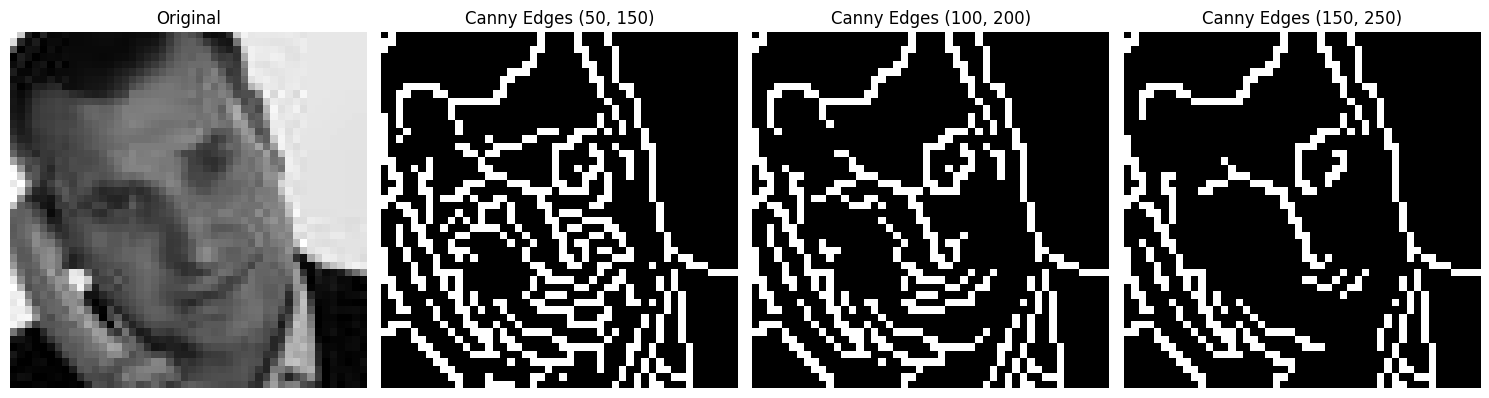

In [25]:
def apply_canny_edge_detection(image_path, thresholds=[(50, 150), (100, 200), (150, 250)]):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    edge_images = []

    for low_thresh, high_thresh in thresholds:
        edges = cv2.Canny(img, low_thresh, high_thresh)
        edge_images.append(edges)

    return img, edge_images

original, edges_list = apply_canny_edge_detection(img_path)

fig, axes = plt.subplots(1, 4, figsize=(15, 4))
axes[0].imshow(original, cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')

thresholds = [(50, 150), (100, 200), (150, 250)]
for i, (edges, thresh) in enumerate(zip(edges_list, thresholds)):
    axes[i+1].imshow(edges, cmap='gray')
    axes[i+1].set_title(f'Canny Edges {thresh}')
    axes[i+1].axis('off')

plt.tight_layout()
plt.show()


 # **Morphologica**l **Operations**

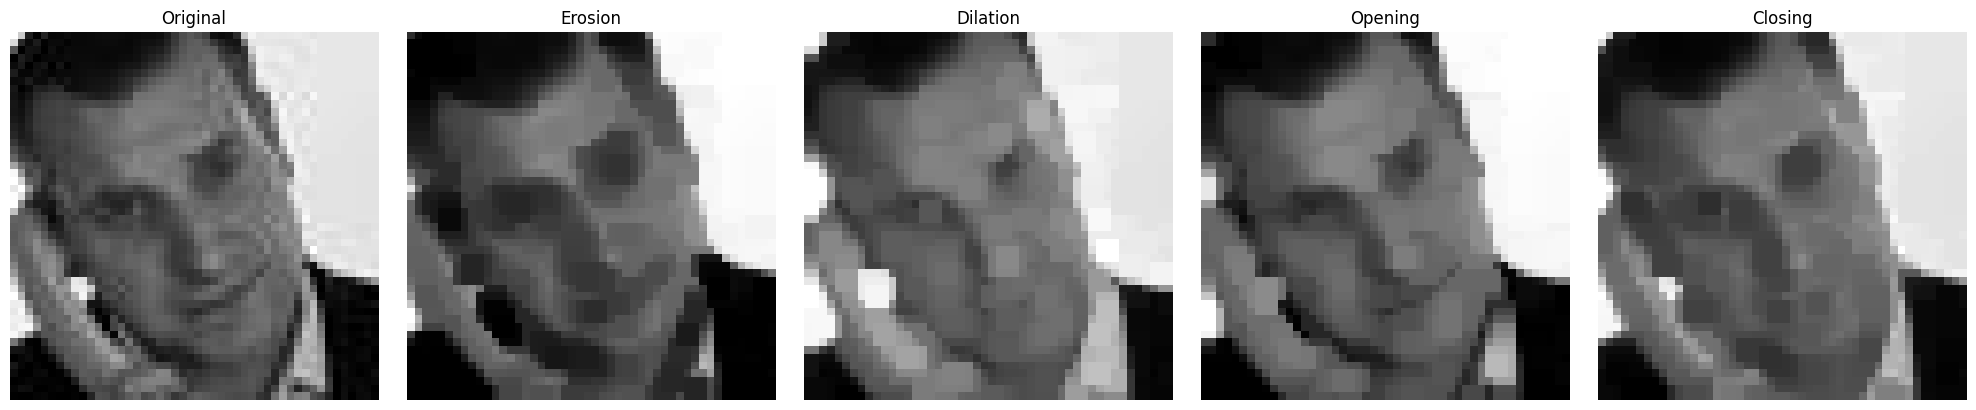

In [26]:
def apply_morphological_operations(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    kernel = np.ones((3,3), np.uint8)

    erosion = cv2.erode(img, kernel, iterations=1)
    dilation = cv2.dilate(img, kernel, iterations=1)
    opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)

    return img, erosion, dilation, opening, closing

results = apply_morphological_operations(img_path)
titles = ['Original', 'Erosion', 'Dilation', 'Opening', 'Closing']

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, (result, title) in enumerate(zip(results, titles)):
    axes[i].imshow(result, cmap='gray')
    axes[i].set_title(title)
    axes[i].axis('off')

plt.tight_layout()
plt.show()


 # **Adaptive Thresholding**

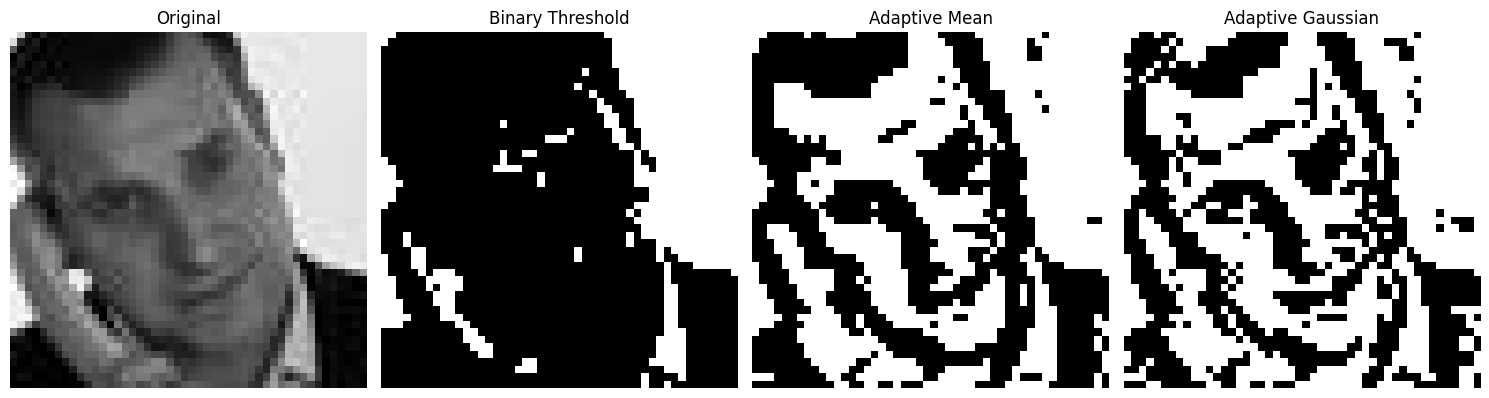

In [27]:
def apply_adaptive_thresholding(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    ret, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    adaptive_mean = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
    adaptive_gaussian = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    return img, binary, adaptive_mean, adaptive_gaussian

original, binary, adaptive_mean, adaptive_gaussian = apply_adaptive_thresholding(img_path)

fig, axes = plt.subplots(1, 4, figsize=(15, 4))
images = [original, binary, adaptive_mean, adaptive_gaussian]
titles = ['Original', 'Binary Threshold', 'Adaptive Mean', 'Adaptive Gaussian']

for i, (img, title) in enumerate(zip(images, titles)):
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(title)
    axes[i].axis('off')

plt.tight_layout()
plt.show()


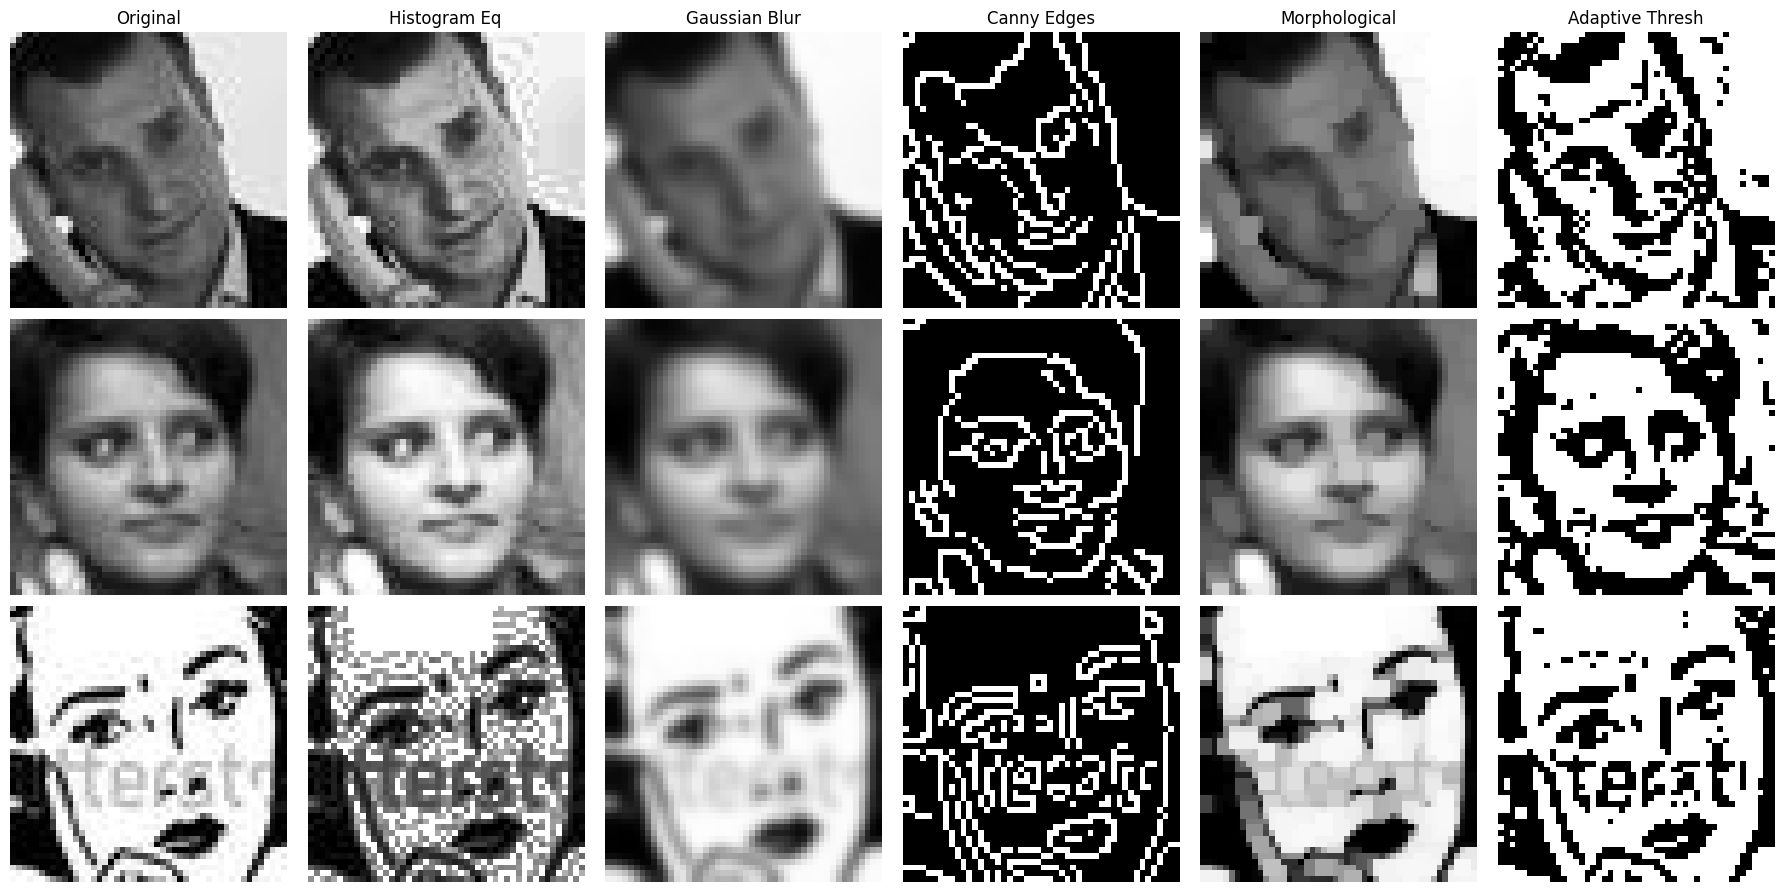

In [28]:
sample_images = []
for emotion in emotion_classes[:3]:
    emotion_path = os.path.join(train_dir, emotion)
    img_file = os.listdir(emotion_path)[0]
    img_path = os.path.join(emotion_path, img_file)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    sample_images.append((img, emotion))

fig, axes = plt.subplots(3, 6, figsize=(18, 9))

for row, (img, emotion) in enumerate(sample_images):
    equalized = cv2.equalizeHist(img)
    blurred = cv2.GaussianBlur(img, (5, 5), 0)
    edges = cv2.Canny(img, 100, 200)
    kernel = np.ones((3,3), np.uint8)
    morphed = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    adaptive = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    processed_images = [img, equalized, blurred, edges, morphed, adaptive]
    titles = ['Original', 'Histogram Eq', 'Gaussian Blur', 'Canny Edges', 'Morphological', 'Adaptive Thresh']

    for col, (processed, title) in enumerate(zip(processed_images, titles)):
        axes[row, col].imshow(processed, cmap='gray')
        if row == 0:
            axes[row, col].set_title(title)
        if col == 0:
            axes[row, col].set_ylabel(emotion, rotation=0, ha='right')
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()


# **Class Distribution**

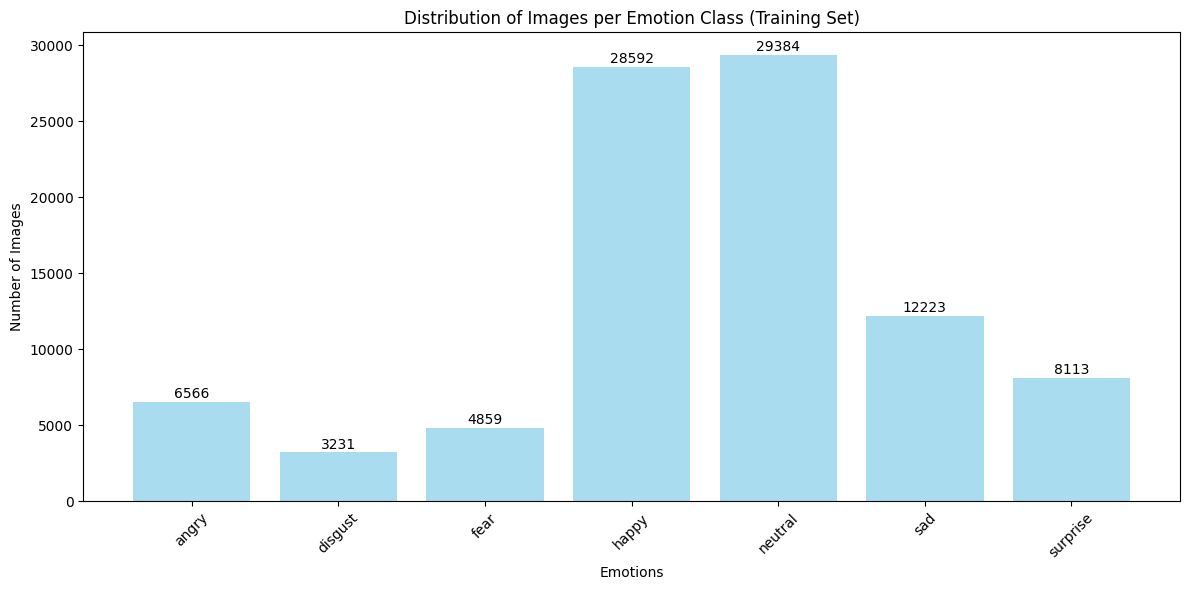

In [12]:
emotions = list(train_counts.keys())
counts = list(train_counts.values())

plt.figure(figsize=(12, 6))
bars = plt.bar(emotions, counts, color='skyblue', alpha=0.7)
plt.title('Distribution of Images per Emotion Class (Training Set)')
plt.xlabel('Emotions')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)

for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
             str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [29]:
if imbalance_ratio > 2.0:
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2],
        zoom_range=0.2,
        fill_mode='nearest',
        preprocessing_function=lambda x: cv2.equalizeHist(x.astype(np.uint8)) if len(x.shape) == 2 else x
    )
    print("Enhanced data augmentation with histogram equalization configured")
else:
    datagen = ImageDataGenerator(
        rescale=1./255,
        preprocessing_function=lambda x: cv2.equalizeHist((x*255).astype(np.uint8))/255.0 if len(x.shape) == 2 else x
    )
    print("Basic preprocessing with histogram equalization configured")


Enhanced data augmentation with histogram equalization configured


In [30]:
def process_image_batch(directory, num_samples=100):
    processed_data = {
        'original': [],
        'histogram_eq': [],
        'gaussian_blur': [],
        'processed_count': 0
    }

    for emotion in emotion_classes:
        emotion_path = os.path.join(directory, emotion)
        image_files = os.listdir(emotion_path)

        sample_size = min(num_samples // len(emotion_classes), len(image_files))
        selected_files = random.sample(image_files, sample_size)

        for img_file in selected_files:
            img_path = os.path.join(emotion_path, img_file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (48, 48))

            hist_eq = cv2.equalizeHist(img)
            gaussian = cv2.GaussianBlur(img, (3, 3), 0)

            processed_data['original'].append(img)
            processed_data['histogram_eq'].append(hist_eq)
            processed_data['gaussian_blur'].append(gaussian)
            processed_data['processed_count'] += 1

    return processed_data

processed_batch = process_image_batch(train_dir)
print(f"Processed {processed_batch['processed_count']} images with multiple techniques")

original_mean = np.mean([img.mean() for img in processed_batch['original']])
hist_eq_mean = np.mean([img.mean() for img in processed_batch['histogram_eq']])
gaussian_mean = np.mean([img.mean() for img in processed_batch['gaussian_blur']])

print(f"Average pixel intensity - Original: {original_mean:.2f}")
print(f"Average pixel intensity - Histogram Equalized: {hist_eq_mean:.2f}")
print(f"Average pixel intensity - Gaussian Blurred: {gaussian_mean:.2f}")


Processed 98 images with multiple techniques
Average pixel intensity - Original: 124.00
Average pixel intensity - Histogram Equalized: 127.95
Average pixel intensity - Gaussian Blurred: 124.04


# **Check for Class Imbalance**

In [13]:
max_count = max(train_counts.values())
min_count = min(train_counts.values())
imbalance_ratio = max_count / min_count

print(f"Maximum images in a class: {max_count}")
print(f"Minimum images in a class: {min_count}")
print(f"Imbalance ratio: {imbalance_ratio:.2f}")

if imbalance_ratio > 2.0:
    print("Significant class imbalance detected. Data augmentation recommended.")
else:
    print("Class distribution is relatively balanced.")


Maximum images in a class: 29384
Minimum images in a class: 3231
Imbalance ratio: 9.09
Significant class imbalance detected. Data augmentation recommended.


In [14]:
def load_sample_images(directory, num_samples=5):
    sample_data = []

    for emotion in emotion_classes:
        emotion_path = os.path.join(directory, emotion)
        image_files = os.listdir(emotion_path)

        samples = random.sample(image_files, min(num_samples, len(image_files)))

        for img_file in samples:
            img_path = os.path.join(emotion_path, img_file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            sample_data.append({
                'emotion': emotion,
                'image': img,
                'shape': img.shape,
                'size': img.size
            })

    return sample_data

sample_data = load_sample_images(train_dir)
print(f"Loaded {len(sample_data)} sample images")


Loaded 35 sample images


# **Analyze Image Properties**

In [15]:
shapes = [data['shape'] for data in sample_data]
sizes = [data['size'] for data in sample_data]

shape_counter = Counter(shapes)
print("Image shapes distribution:")
for shape, count in shape_counter.items():
    print(f"{shape}: {count} images")

print(f"\nAverage image size: {np.mean(sizes):.0f} pixels")
print(f"Image size range: {min(sizes)} - {max(sizes)} pixels")

sample_img = sample_data[0]['image']
print(f"\nSample image details:")
print(f"Shape: {sample_img.shape}")
print(f"Data type: {sample_img.dtype}")
print(f"Min pixel value: {sample_img.min()}")
print(f"Max pixel value: {sample_img.max()}")


Image shapes distribution:
(48, 48): 35 images

Average image size: 2304 pixels
Image size range: 2304 - 2304 pixels

Sample image details:
Shape: (48, 48)
Data type: uint8
Min pixel value: 0
Max pixel value: 228


# **Data Augmentation**

In [16]:
if imbalance_ratio > 2.0:
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2],
        zoom_range=0.2,
        fill_mode='nearest'
    )
    print("Data augmentation configured")
else:
    datagen = ImageDataGenerator(rescale=1./255)
    print("Basic data normalization configured")


Data augmentation configured


# **Data Generators**

In [21]:
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=True
)

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    val_dir,
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False
)

print("Data generators created successfully")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Class indices: {train_generator.class_indices}")

Found 92968 images belonging to 7 classes.
Found 17356 images belonging to 7 classes.
Data generators created successfully
Training samples: 92968
Validation samples: 17356
Class indices: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


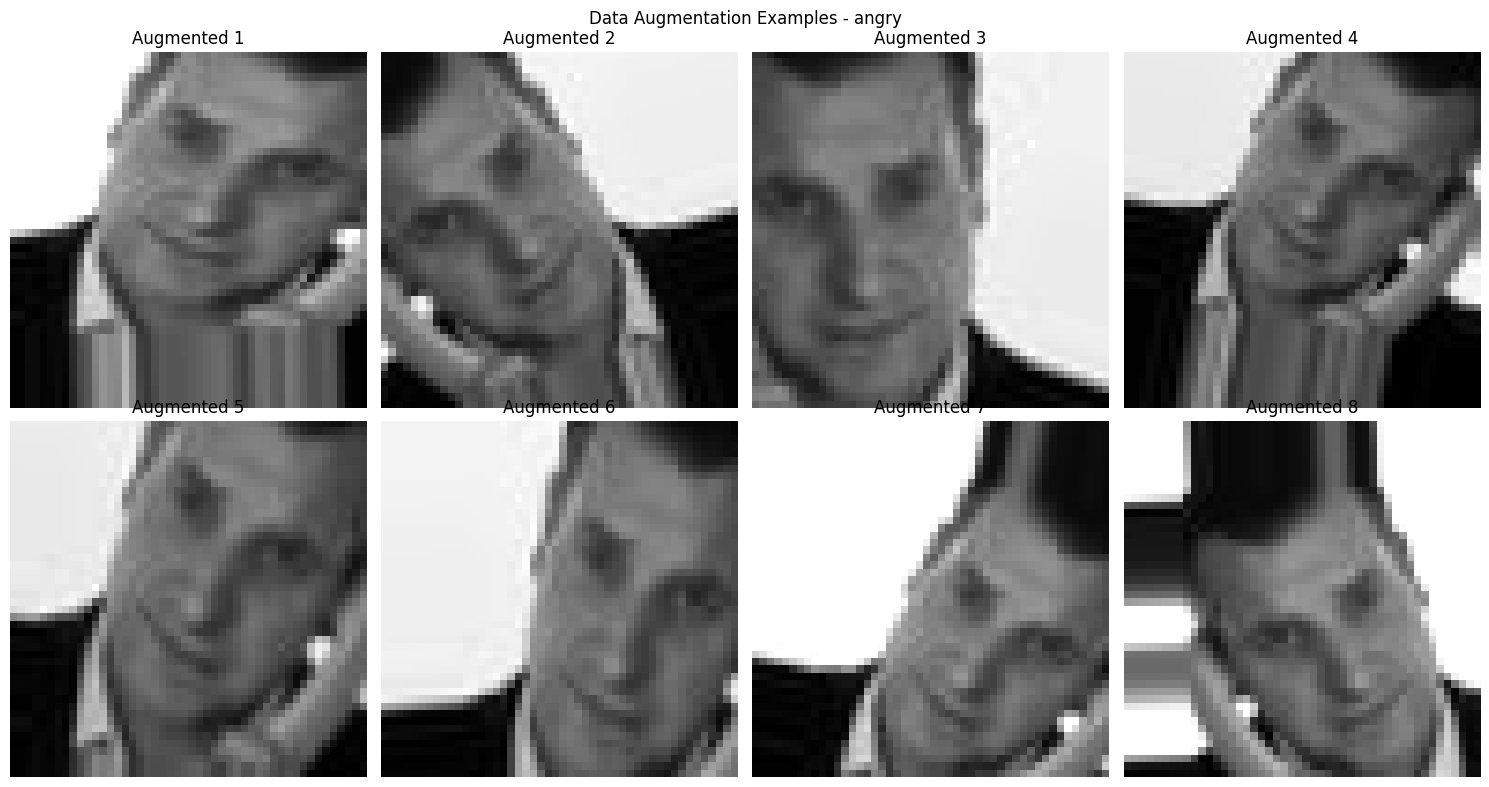

In [22]:
if imbalance_ratio > 2.0:
    sample_emotion = emotion_classes[0]
    sample_path = os.path.join(train_dir, sample_emotion)
    sample_files = os.listdir(sample_path)

    img = Image.open(os.path.join(sample_path, sample_files[0]))
    img_array = np.array(img).reshape((1,) + img.size + (1,))

    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    axes = axes.flatten()

    i = 0
    for batch in datagen.flow(img_array, batch_size=1):
        axes[i].imshow(batch[0].squeeze(), cmap='gray')
        axes[i].set_title(f'Augmented {i+1}')
        axes[i].axis('off')
        i += 1
        if i >= 8:
            break

    plt.suptitle(f'Data Augmentation Examples - {sample_emotion}')
    plt.tight_layout()
    plt.show()


In [18]:
total_train = sum(train_counts.values())
total_val = sum(val_counts.values())
total_test = sum(test_counts.values())
total_images = total_train + total_val + total_test

print("DATASET SUMMARY")
print("="*50)
print(f"Training images: {total_train}")
print(f"Validation images: {total_val}")
print(f"Test images: {total_test}")
print(f"Total images: {total_images}")
print(f"Number of classes: {len(emotion_classes)}")
print(f"Image dimensions: 48x48 pixels (grayscale)")
print(f"Data augmentation: {'Enabled' if imbalance_ratio > 2.0 else 'Disabled'}")


DATASET SUMMARY
Training images: 92968
Validation images: 0
Test images: 17356
Total images: 110324
Number of classes: 7
Image dimensions: 48x48 pixels (grayscale)
Data augmentation: Enabled
